# How to train an KAN using the Pipeline

## Import classes and define paths

In [1]:
from pyLOM import NN
from pathlib import Path

import torch

import warnings
warnings.filterwarnings("ignore")

0 Warning! Import - NVTX not present!
/home/david/miniconda/envs/pruebasphinx/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
E0000 00:00:1742310863.229104   34093 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742310863.234553   34093 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
DATA_DIR = Path.cwd().parent.parent.parent.parent / "Testsuite/DATA"
CASE_DIR = Path.cwd() / "results"

NN.create_results_folder(CASE_DIR / 'models')
NN.create_results_folder(CASE_DIR / 'hyperparameters')
NN.create_results_folder(CASE_DIR / 'plots')

Folder already exists: /home/david/Desktop/pyLowOrder/docs/source/notebook_examples/NN/results/models
Folder already exists: /home/david/Desktop/pyLowOrder/docs/source/notebook_examples/NN/results/hyperparameters
Folder already exists: /home/david/Desktop/pyLowOrder/docs/source/notebook_examples/NN/results/plots


## Define scalers if needed

Here, we create 2 minmax scalers, one for scaling the inputs, and other for the outputs. They will be passed to the dataset and the data will be automatically scaled

In [3]:
input_scaler = NN.MinMaxScaler()
output_scaler = NN.MinMaxScaler()

## Create datasets
For this example, a dataset of airfoils generated with XFoil is used. As inputs, the model will receive the x and y coordinates of a point of the airfoil, the Reynolds number and the angle of attack; and the output will be the cp on that point

In [4]:
dataset = NN.Dataset.load(
    DATA_DIR / 'AIRFOIL.h5',
    field_names=["cp"],
    add_mesh_coordinates=True,
    variables_names=["AoA", "Re"],
    inputs_scaler=input_scaler,
    outputs_scaler=output_scaler,
)
train_dataset, test_dataset = dataset.get_splits_by_parameters([0.8, 0.2])

After creating the datasets, we can see the shape of the tensors

In [5]:
x, y = train_dataset[:]
print("\tTrain dataset length: ", len(train_dataset))
print("\tTest dataset length: ", len(test_dataset))
print("\tX, y train shapes:", x.shape, y.shape)

	Train dataset length:  27720
	Test dataset length:  6831
	X, y train shapes: torch.Size([27720, 4]) torch.Size([27720, 1])


## Model creation

Now, the only thing left is creating the model. For this example we are using a `KAN`

In [6]:
training_params = {
    "epochs": 20,
    "lr": 1e-5,
    'lr_gamma': 0.95,
    'lr_scheduler_step': 10,
    'batch_size': 8,
    "print_eval_rate": 1,
    "optimizer_class": torch.optim.Adam,
    "lr_kwargs":{
        "gamma": 0.95,
        "step_size": 3 * len(train_dataset) // 8 # each 3 epochs
    },
    "max_norm_grad": 0.5,
    "save_logs_path":str(CASE_DIR),
}

We can train the model on a GPU to speed up the training. pyLOM can detect if a GPU is available with ´NN.DEVICE´, that will select the fist GPU.
If many GPUs are available, the device can be define with `device = cuda:i` where `i` is the index of the GPU

In [7]:
device = NN.DEVICE

In [8]:
model = NN.KAN(
    input_size=x.shape[1],
    output_size=y.shape[1],
    hidden_size=31,
    n_layers=3,
    p_dropouts=0.0,
    layer_type=NN.ChebyshevLayer,
    model_name="kan_example_xfoil",
    device=device,
    degree=7
)

Creating model KAN: kan_example_xfoil
	input_size: 4
	output_size: 1
	n_layers: 3
	hidden_size: 31
	layer_type: <class 'pyLOM.NN.architectures.kan.ChebyshevLayer'>
	p_dropouts: 0.0
	device: cpu
	total_size (trained params):	24304


## Run the pipeline

In [9]:
pipeline = NN.Pipeline(
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    model=model,
    training_params=training_params,
)
training_logs = pipeline.run()


TRAINNING MODEL kan_example_xfoil

Conditions:
	epochs:     20
	batch size: 2**3
	optimizer class:  <class 'torch.optim.adam.Adam'>
	scheduler:  StepLR
	loss_fn:  MSELoss()
	save_path:  /home/david/Desktop/pyLowOrder/docs/source/notebook_examples/NN/results
	
Scheduler conditions:
	gamma: 0.95
	step_size: 10395
   
Epoch 1/20, Train Loss: 3.2465e-02, Test Loss: 3.6504e-03, LR: 1.00e-05
Epoch 2/20, Train Loss: 2.5051e-03, Test Loss: 1.3975e-03, LR: 1.00e-05
Epoch 3/20, Train Loss: 1.0072e-03, Test Loss: 1.1278e-03, LR: 9.50e-06
Epoch 4/20, Train Loss: 7.0540e-04, Test Loss: 6.6096e-04, LR: 9.50e-06
Epoch 5/20, Train Loss: 5.5156e-04, Test Loss: 6.9895e-04, LR: 9.50e-06
Epoch 6/20, Train Loss: 4.6177e-04, Test Loss: 4.5064e-04, LR: 9.03e-06
Epoch 7/20, Train Loss: 3.9933e-04, Test Loss: 3.9053e-04, LR: 9.03e-06
Epoch 8/20, Train Loss: 3.5597e-04, Test Loss: 3.4745e-04, LR: 9.03e-06
Epoch 9/20, Train Loss: 3.1841e-04, Test Loss: 3.2785e-04, LR: 8.57e-06
Epoch 10/20, Train Loss: 2.9913e-0

To save the model:

In [10]:
model.save(path=str(CASE_DIR / "models"))

## Show plots

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def true_vs_pred_plot(y_true, y_pred):
    """
    Auxiliary function to plot the true vs predicted values
    """
    num_plots = y_true.shape[1]
    plt.figure(figsize=(10, 5 * num_plots))
    for j in range(num_plots):
        plt.subplot(num_plots, 1, j + 1)
        plt.scatter(y_true[:, j], y_pred[:, j], s=1, c="b", alpha=0.5)
        plt.xlabel("True values")
        plt.ylabel("Predicted values")
        plt.title(f"Scatterplot for Component {j+1}")
        plt.grid(True)

    plt.tight_layout()
    plt.show()

def plot_train_test_loss(train_loss, test_loss):
    """
    Auxiliary function to plot the training and test loss
    """
    plt.figure()
    plt.plot(range(1, len(train_loss) + 1), train_loss, label="Training Loss")
    total_epochs = len(test_loss) # test loss is calculated at the end of each epoch
    total_iters = len(train_loss) # train loss is calculated at the end of each iteration/batch
    iters_per_epoch = total_iters // total_epochs
    plt.plot(np.arange(iters_per_epoch, total_iters+1, step=iters_per_epoch), test_loss, label="Test Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Training Loss vs Epoch")
    plt.yscale("log")
    plt.legend()
    plt.grid()
    plt.show()

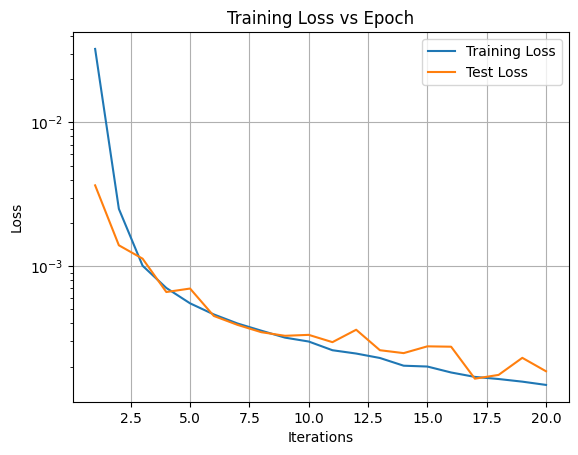

In [12]:
plot_train_test_loss(training_logs['train_loss'], training_logs['test_loss'])

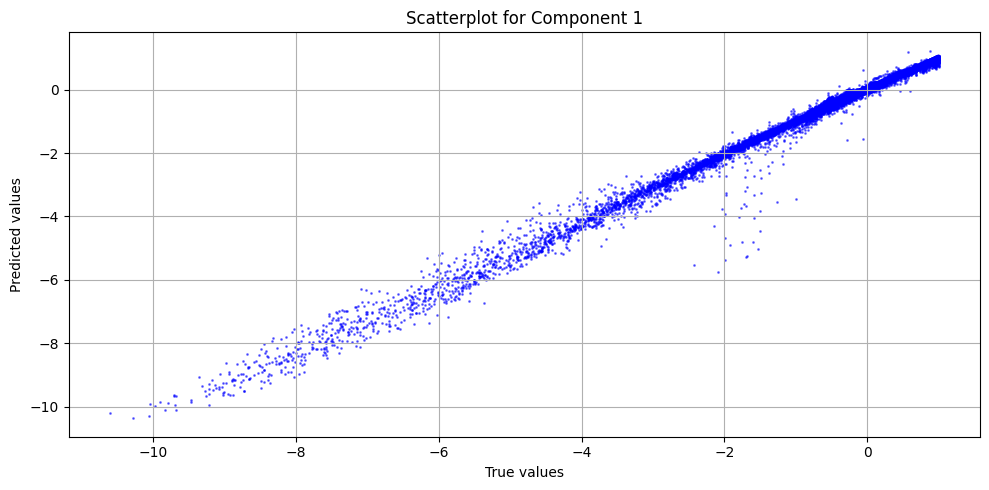

In [13]:
preds = model.predict(train_dataset, batch_size=250)

scaled_preds = output_scaler.inverse_transform([preds])[0]
scaled_y = output_scaler.inverse_transform([train_dataset[:][1]])[0]
true_vs_pred_plot(scaled_y, scaled_preds)

## Evaluate the model with some metrics

In [14]:
evaluator = NN.RegressionEvaluator()
evaluator(scaled_y, scaled_preds)
evaluator.print_metrics()


Regression evaluator metrics:
mse: 0.0198
rmse: 0.1406
mae: 0.0645
mre: 116.0480%
ae_95: 0.2076
ae_99: 0.5622
r2: 0.9899
l2_error: 0.0915


As you can see, this example is very similar that the one with the MLP, it just changes the model definition. This shows the power of pyLOM when training different models